<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W3/ungraded_lab/C2_W3_Lab_1_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Transfer Learning

In this lab, you will see how you can use a pre-trained model to achieve good results even with a small training dataset. This is called _transfer learning_ and you do this by leveraging the trained layers of an existing model and adding your own layers to fit your application. For example, you can:

1. just get the convolution layers of one model
2. attach some dense layers onto it
3. train just the dense network
4. evaluate the results

Doing this will allow you to save time building your application because you will essentially skip weeks of training time of very deep networks. You will just use the features it has learned and tweak it for your dataset. Let's see how these are done in the next sections.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

## Setup the pretrained model

You will need to prepare pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as your base model. To do that, you need to:

1. Set the input shape to fit your application. In this case. set it to `150x150x3` as you've been doing in the last few labs.

2. Pick and freeze the convolution layers to take advantage of the features it has learned already.

3. Add dense layers which you will train.

Let's see how to do these in the next cells.

First, in preparing the input to the model, you want to fetch the pretrained weights of the `InceptionV3` model and remove the fully connected layer at the end because you will be replacing it later. You will also specify the input shape that your model will accept. Lastly, you want to freeze the weights of these layers because they have been trained already.

In [43]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [44]:
import requests
import os

base_path = '../../../data/models/'
file_name = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
path = os.path.join(base_path, file_name)
url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'  # without the -O

# ensure path exists
os.makedirs(base_path, exist_ok=True)

# download file
response = requests.get(url)
with open(path, 'wb') as file:
    file.write(response.content)

In [45]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, # Exclude final dense layers; used for feature extraction.
                                weights = None)      # Do not load any pre-trained weights.

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(path)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False  # Prevent the layers' weights from being updated during training.

You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use. As Laurence showed in the exercise, you will use up to `mixed7` as your base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. `mixed7` on the other hand will be more generalized and you can start with that for your application. After the exercise, feel free to modify and use other layers to see what the results you get.

In [46]:
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 74, 74, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_564 (Batch  (None, 74, 74, 32)  96          ['conv2d_564[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [47]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Add dense layers for your classifier

Next, you will add dense layers to your model. These will be the layers that you will train and is tasked with recognizing cats and dogs. You will add a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer as well to regularize the output and avoid overfitting.

In [48]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 74, 74, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_564 (Batch  (None, 74, 74, 32)  96          ['conv2d_564[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [49]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

## Prepare the dataset

Now you will prepare the dataset. This is basically the same code as the one you used in the data augmentation lab.

In [50]:
# Download the dataset
# !wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

In [51]:
# Code that works locally
import requests
import zipfile
import os

url = 'https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip'

# Path to save the downloaded file
base_path = '../../../data'
file_name = 'cats_and_dogs_filtered.zip'
local_zip = os.path.join(base_path, file_name)

# Download the file
response = requests.get(url)
with open(local_zip, 'wb') as file:
    file.write(response.content)

# Unzip the dataset
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(base_path)

# Delete zip file
os.remove(local_zip)

# Check if files are extracted
print(f"Files extracted to: {os.path.abspath(base_path)}")

Files extracted to: c:\wagon\code\tensorflow-1-public\data


In [52]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
# zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
# zip_ref.extractall("tmp/")
# zip_ref.close()

# Define our example directories and files
#base_dir = 'tmp/cats_and_dogs_filtered'
base_dir = os.path.join(base_path, 'cats_and_dogs_filtered')

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train the model

With that, you can now train the model. You will do 20 epochs and plot the results afterwards.

In [53]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 24s - loss: 0.3347 - accuracy: 0.8710 - val_loss: 0.0985 - val_accuracy: 0.9570 - 24s/epoch - 236ms/step
Epoch 2/20
100/100 - 10s - loss: 0.2105 - accuracy: 0.9210 - val_loss: 0.1196 - val_accuracy: 0.9550 - 10s/epoch - 98ms/step
Epoch 3/20
100/100 - 10s - loss: 0.1954 - accuracy: 0.9320 - val_loss: 0.1658 - val_accuracy: 0.9440 - 10s/epoch - 97ms/step
Epoch 4/20
100/100 - 10s - loss: 0.2080 - accuracy: 0.9215 - val_loss: 0.1265 - val_accuracy: 0.9610 - 10s/epoch - 97ms/step
Epoch 5/20
100/100 - 10s - loss: 0.2087 - accuracy: 0.9300 - val_loss: 0.1098 - val_accuracy: 0.9640 - 10s/epoch - 97ms/step
Epoch 6/20
100/100 - 10s - loss: 0.1578 - accuracy: 0.9420 - val_loss: 0.0884 - val_accuracy: 0.9660 - 10s/epoch - 98ms/step
Epoch 7/20
100/100 - 10s - loss: 0.1744 - accuracy: 0.9370 - val_loss: 0.0925 - val_accuracy: 0.9650 - 10s/epoch - 98ms/step
Epoch 8/20
100/100 - 10s - loss: 0.1659 - accuracy: 0.9400 - val_loss: 0.1087 - val_accuracy: 0.9700 - 10s/epoch - 97ms/step

```python
with freezing layers

Epoch 1/20
100/100 - 24s - loss: 0.3438 - accuracy: 0.8690 - val_loss: 0.2176 - val_accuracy: 0.9180 - 24s/epoch - 239ms/step
Epoch 2/20
100/100 - 10s - loss: 0.2201 - accuracy: 0.9145 - val_loss: 0.1175 - val_accuracy: 0.9610 - 10s/epoch - 99ms/step
Epoch 3/20
100/100 - 9s - loss: 0.2090 - accuracy: 0.9170 - val_loss: 0.1130 - val_accuracy: 0.9640 - 9s/epoch - 94ms/step
Epoch 4/20
100/100 - 9s - loss: 0.1926 - accuracy: 0.9270 - val_loss: 0.1003 - val_accuracy: 0.9680 - 9s/epoch - 94ms/step
Epoch 5/20
100/100 - 9s - loss: 0.1868 - accuracy: 0.9320 - val_loss: 0.1282 - val_accuracy: 0.9610 - 9s/epoch - 93ms/step
Epoch 6/20
100/100 - 9s - loss: 0.1865 - accuracy: 0.9390 - val_loss: 0.1130 - val_accuracy: 0.9650 - 9s/epoch - 95ms/step
Epoch 7/20
100/100 - 9s - loss: 0.1937 - accuracy: 0.9305 - val_loss: 0.0969 - val_accuracy: 0.9670 - 9s/epoch - 94ms/step
Epoch 8/20
100/100 - 10s - loss: 0.1541 - accuracy: 0.9435 - val_loss: 0.1230 - val_accuracy: 0.9610 - 10s/epoch - 97ms/step
Epoch 9/20
100/100 - 10s - loss: 0.1572 - accuracy: 0.9500 - val_loss: 0.0922 - val_accuracy: 0.9700 - 10s/epoch - 98ms/step
Epoch 10/20
100/100 - 10s - loss: 0.1650 - accuracy: 0.9465 - val_loss: 0.1333 - val_accuracy: 0.9620 - 10s/epoch - 99ms/step
Epoch 11/20
100/100 - 10s - loss: 0.1358 - accuracy: 0.9495 - val_loss: 0.1235 - val_accuracy: 0.9660 - 10s/epoch - 96ms/step
Epoch 12/20
100/100 - 10s - loss: 0.1737 - accuracy: 0.9450 - val_loss: 0.1340 - val_accuracy: 0.9520 - 10s/epoch - 95ms/step
Epoch 13/20
100/100 - 9s - loss: 0.1276 - accuracy: 0.9515 - val_loss: 0.1083 - val_accuracy: 0.9690 - 9s/epoch - 94ms/step
Epoch 14/20
100/100 - 10s - loss: 0.1498 - accuracy: 0.9430 - val_loss: 0.1150 - val_accuracy: 0.9640 - 10s/epoch - 96ms/step
Epoch 15/20
100/100 - 10s - loss: 0.1516 - accuracy: 0.9525 - val_loss: 0.1084 - val_accuracy: 0.9690 - 10s/epoch - 96ms/step
Epoch 16/20
100/100 - 10s - loss: 0.1572 - accuracy: 0.9470 - val_loss: 0.1588 - val_accuracy: 0.9540 - 10s/epoch - 98ms/step
Epoch 17/20
100/100 - 10s - loss: 0.1427 - accuracy: 0.9490 - val_loss: 0.1170 - val_accuracy: 0.9700 - 10s/epoch - 98ms/step
Epoch 18/20
100/100 - 10s - loss: 0.1292 - accuracy: 0.9580 - val_loss: 0.1466 - val_accuracy: 0.9620 - 10s/epoch - 97ms/step
Epoch 19/20
100/100 - 9s - loss: 0.1071 - accuracy: 0.9555 - val_loss: 0.1243 - val_accuracy: 0.9670 - 9s/epoch - 95ms/step
Epoch 20/20
100/100 - 9s - loss: 0.1301 - accuracy: 0.9550 - val_loss: 0.1319 - val_accuracy: 0.9630 - 9s/epoch - 94ms/step


without freezing layers

Epoch 1/20
100/100 - 32s - loss: 0.3697 - accuracy: 0.8400 - val_loss: 0.3595 - val_accuracy: 0.9140 - 32s/epoch - 315ms/step
Epoch 2/20
100/100 - 10s - loss: 0.2227 - accuracy: 0.9080 - val_loss: 0.2001 - val_accuracy: 0.9480 - 10s/epoch - 99ms/step
Epoch 3/20
100/100 - 10s - loss: 0.1765 - accuracy: 0.9345 - val_loss: 0.2188 - val_accuracy: 0.9580 - 10s/epoch - 100ms/step
Epoch 4/20
100/100 - 10s - loss: 0.1552 - accuracy: 0.9380 - val_loss: 0.7529 - val_accuracy: 0.9250 - 10s/epoch - 99ms/step
Epoch 5/20
100/100 - 10s - loss: 0.1342 - accuracy: 0.9515 - val_loss: 0.3002 - val_accuracy: 0.9640 - 10s/epoch - 101ms/step
Epoch 6/20
100/100 - 10s - loss: 0.1205 - accuracy: 0.9610 - val_loss: 0.2677 - val_accuracy: 0.9590 - 10s/epoch - 100ms/step
Epoch 7/20
100/100 - 10s - loss: 0.1413 - accuracy: 0.9605 - val_loss: 0.7452 - val_accuracy: 0.9580 - 10s/epoch - 101ms/step
Epoch 8/20
100/100 - 10s - loss: 0.0946 - accuracy: 0.9690 - val_loss: 0.3574 - val_accuracy: 0.9550 - 10s/epoch - 99ms/step
Epoch 9/20
100/100 - 10s - loss: 0.1359 - accuracy: 0.9625 - val_loss: 0.6323 - val_accuracy: 0.9520 - 10s/epoch - 100ms/step
Epoch 10/20
100/100 - 10s - loss: 0.1011 - accuracy: 0.9725 - val_loss: 0.7085 - val_accuracy: 0.9610 - 10s/epoch - 100ms/step
Epoch 11/20
100/100 - 10s - loss: 0.0875 - accuracy: 0.9700 - val_loss: 0.3422 - val_accuracy: 0.9660 - 10s/epoch - 101ms/step
Epoch 12/20
100/100 - 10s - loss: 0.0871 - accuracy: 0.9725 - val_loss: 0.3484 - val_accuracy: 0.9540 - 10s/epoch - 100ms/step
Epoch 13/20
100/100 - 10s - loss: 0.0971 - accuracy: 0.9745 - val_loss: 1.1989 - val_accuracy: 0.9030 - 10s/epoch - 99ms/step
Epoch 14/20
100/100 - 10s - loss: 0.0680 - accuracy: 0.9820 - val_loss: 0.2448 - val_accuracy: 0.9580 - 10s/epoch - 99ms/step
Epoch 15/20
100/100 - 10s - loss: 0.0799 - accuracy: 0.9735 - val_loss: 0.3434 - val_accuracy: 0.9670 - 10s/epoch - 97ms/step
Epoch 16/20
100/100 - 10s - loss: 0.0613 - accuracy: 0.9815 - val_loss: 13.4375 - val_accuracy: 0.9570 - 10s/epoch - 95ms/step
Epoch 17/20
100/100 - 10s - loss: 0.0754 - accuracy: 0.9785 - val_loss: 5.5575 - val_accuracy: 0.9570 - 10s/epoch - 95ms/step
Epoch 18/20
100/100 - 9s - loss: 0.0520 - accuracy: 0.9805 - val_loss: 0.5496 - val_accuracy: 0.9730 - 9s/epoch - 95ms/step
Epoch 19/20
100/100 - 10s - loss: 0.0935 - accuracy: 0.9815 - val_loss: 0.7395 - val_accuracy: 0.9600 - 10s/epoch - 96ms/step
Epoch 20/20
100/100 - 10s - loss: 0.0725 - accuracy: 0.9800 - val_loss: 0.9159 - val_accuracy: 0.9600 - 10s/epoch - 97ms/step
```

## Evaluate the results

You will use the same code to plot the results. As you can see, the validation accuracy is also trending upwards as your training accuracy improves. This is a good sign that your model is no longer overfitting!

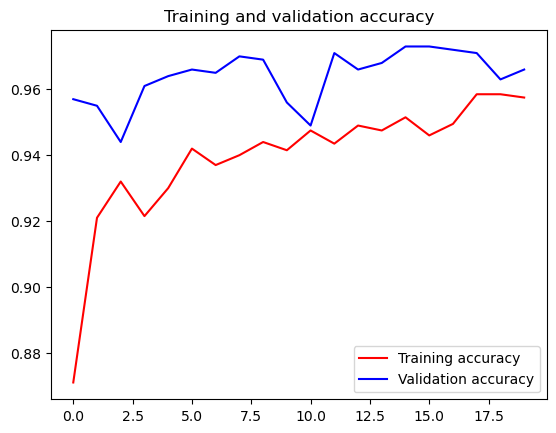

<Figure size 640x480 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In the scenario described by Andrew Ng's Coursera course, using `include_top = False` and `weights = None` together is actually very strategic and not redundant when followed by loading specific pretrained weights (`weights=path`) and freezing the layers. This approach combines several techniques to leverage a pre-trained model effectively for a new, related task through transfer learning. Let’s break down the steps and the rationale behind each:

### Step-by-Step Analysis

1. **Setting `include_top = False`**:
    - This setting is used to remove the original top layers (usually dense layers) that were specific to the classification tasks for which the model was initially trained (like the 1000-class prediction in ImageNet).
    - It allows you to replace these with layers that are better suited to your specific task, which in this context involves classifying images as either cats or dogs.

2. **Setting `weights = None`**:
    - Initially, this configuration specifies that the model should not automatically load the default pretrained weights at the time of initialization.
    - This gives you control over which weights the model starts with, allowing for more flexibility, especially if you plan to load a different set of weights or modify the initialization in some way.

3. **Loading Specific Pretrained Weights**:
    - After initializing the model with `weights = None`, the course instructs to manually load pretrained weights with `pre_trained_model.load_weights(path)`.
    - These weights are specifically the convolutional base of InceptionV3 without the top layers (`_notop`), tailored for feature extraction rather than for a specific classification task.
    - This step ensures that you're using a robust feature extractor trained on a broad dataset like ImageNet, but without the final classification layers that don't pertain to your task.

4. **Freezing the Convolutional Base**:
    - The next step is to freeze the layers of this model by setting `layer.trainable = False`. This is crucial because it preserves the generic features these layers have learned, which are generally applicable to a wide range of image recognition tasks.
    - Freezing prevents the pretrained weights from being updated during training. This is important when your dataset is relatively small or not diverse enough to retrain a deep network without overfitting.

5. **Adding Custom Dense Layers**:
    - On top of the frozen convolutional base, new trainable layers are added. These layers are designed to learn features specific to the new dataset (cats and dogs in this example).
    - This approach allows for customization where the new data's specific features dictate the learning in these top layers, while the broad features extracted from the generic dataset are retained in the frozen layers.

### Conclusion

This methodology is a classic example of transfer learning, where you take a pre-trained model, repurpose the feature-extracting layers, and then train a new classifier on top for a different but related task. It’s efficient because:
- **Speed**: You skip the time-consuming and computationally expensive process of training the convolutional layers from scratch.
- **Performance**: You leverage the advanced feature-detecting capabilities of a model trained on a much larger dataset.
- **Resource Management**: It’s resource-efficient, requiring less data and computational power to achieve high accuracy.

In essence, the `weights=None` initially followed by loading specific weights and freezing layers is a deliberate strategy to harness the strength of pre-existing models while tailoring them to new tasks with minimal risk of overfitting and lower computational demand. This approach is particularly beneficial when adapting complex models to specific tasks where the availability of large labeled datasets may be limited.

You're on the right track, and your observation about how the weights are handled in this scenario is insightful. Let me clarify how this works and why it's done this way.

### How Pre-trained Models and Weights Work in Keras:

1. **Model Loading Options**:
    - When you load a model like InceptionV3 in Keras, you typically have a few options for the `weights` parameter:
      - **`weights='imagenet'`**: Automatically loads weights pre-trained on the ImageNet dataset.
      - **`weights=None'`**: Initializes the model without any weights, meaning all weights are set randomly.

2. **Purpose of `include_top=False` and `weights=None`**:
    - **`include_top=False`**: This excludes the dense layers at the top of the model, which are specific to the ImageNet classification task (1,000 classes). It's useful when you want to use the model as a feature extractor in transfer learning for a different task.
    - **`weights=None`**: Starts the model with no weights. This might seem counterintuitive in transfer learning where you want to leverage pre-existing knowledge.

3. **Loading Weights Manually**:
    - After initializing the model with `weights=None`, the example explicitly loads a specific weight file with `pre_trained_model.load_weights(path)`.
    - The weights file in this context (`inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5`) is specifically formatted to include only the weights for the convolutional base (i.e., no top dense layers). This file is tailored for use in transfer learning scenarios where the top layers will be replaced or are not relevant.
    - By using this approach, the course makes the learning process explicit and instructional. It demonstrates how you can manually manage model weights, which is a crucial aspect of handling pre-trained models in different contexts.

### Why Not Load Weights Automatically?

- The manual process might be used for educational purposes to illustrate how you can control model configuration in a granular way. It shows you how to manipulate models beyond the standard configurations provided by Keras.
- Alternatively, it could be due to the specific requirements of the dataset or task, where you might want to load a custom set of weights that are not the standard ImageNet weights or where you need to ensure the model structure aligns perfectly with the weights being loaded.

### Summary

- The `InceptionV3` model can indeed come with weights trained on ImageNet, but in the example you're working with, the initial setup with `weights=None` allows for a clear demonstration of how to load and manage weights manually.
- This method is particularly educational and gives flexibility, showing you how to adapt the model for tasks that may require different configurations or custom weight files.
- By loading the weights separately, it also ensures that you are using the convolutional base without the classification layers, tailored specifically to the needs of the transfer learning task at hand.

This process might seem a bit complex initially, but it provides a strong foundation in understanding how to effectively leverage and customize pre-trained models in deep learning. If you have any more questions or need further clarification, feel free to ask!